In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn as sk
from math import sqrt
import yellowbrick
from yellowbrick.regressor import ResidualsPlot
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
data = pd.read_csv('../datasets/Machines.csv', index_col=None)
data = data.iloc[:,1:]
data.head(10)

,Worker,Machine,score
0,1,A,52.0
1,1,A,52.8
2,1,A,53.1
3,2,A,51.8
4,2,A,52.8
5,2,A,53.1
6,3,A,60.0
7,3,A,60.2
8,3,A,58.4
9,4,A,51.1


<AxesSubplot:xlabel='Worker', ylabel='score'>

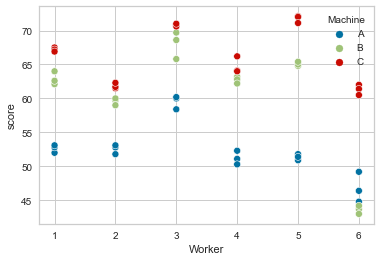

In [3]:
sns.scatterplot(x='Worker', y='score', hue='Machine', data=data)

In [4]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.preprocessing import OrdinalEncoder

OE = OrdinalEncoder()
a = OE.fit_transform(X_train)
b = OE.fit_transform(X_test)

X_train_label = pd.DataFrame(a, columns = X_train.columns)
X_test_label = pd.DataFrame(b, columns = X_test.columns)

# Linear regression considering predictors as fixed effect
Worker and Machine = Fixed effect

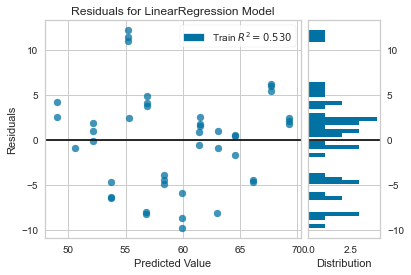

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(X_train_label, y_train)
y_pred = model.predict(X_test_label)

visualizer = ResidualsPlot(estimator=model)
visualizer.fit(X_train_label, y_train)  # Fit the training data to the model
visualizer.poof()

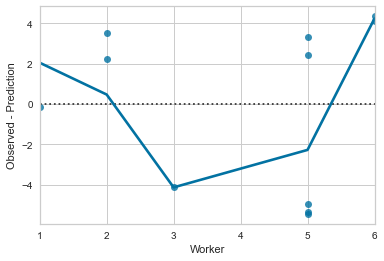

In [7]:
performance = pd.DataFrame()
performance["residuals"] = model.predict(X_test_label) - y_test
performance["Worker"] = data.Worker
performance["predicted"] = model.predict(X_test_label)

ax = sns.residplot(x = "Worker", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [8]:
y_predict = model.predict(X_test_label)
RMSE = sqrt(((y_test-y_predict)**2).values.mean())
print("RMSE: ", RMSE)

RMSE:  4.353060554785513


# Now using MEM

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#md = smf.mixedlm("score ~ 1", data=data, groups=data['Worker'])
#mdf = md.fit()
#print(mdf.summary())

# Fit the mixed-effects model
md = sm.MixedLM.from_formula("score ~ Machine", data, groups=data["Worker"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score    
No. Observations: 54      Method:             REML     
No. Groups:       6       Scale:              9.9960   
Min. group size:  9       Log-Likelihood:     -143.4391
Max. group size:  9       Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    52.356    2.229 23.485 0.000 47.986 56.725
Machine[T.B]  7.967    1.054  7.559 0.000  5.901 10.032
Machine[T.C] 13.917    1.054 13.205 0.000 11.851 15.982
Group Var    26.487    5.813                           



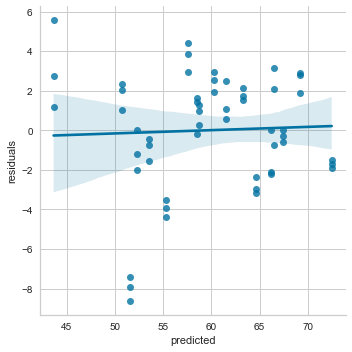

In [10]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["Worker"] = data.Worker
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

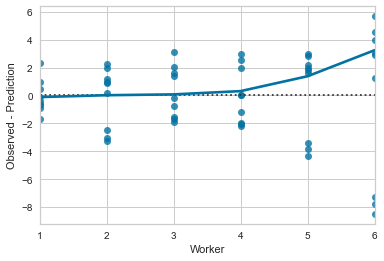

In [11]:
ax = sns.residplot(x = "Worker", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [12]:
y_predict = mdf.fittedvalues
y = data.score
RMSE = sqrt(((y-y_predict)**2).values.mean())
print("RMSE: ", RMSE)

RMSE:  2.924444073742314


## MEM results in reduced RMSE